In [1]:
import os
import pandas as pd
import numpy as np
from visualize import run_eda, transform_original_columns

In [2]:
#Subimos dos niveles para quedar en la carpeta que contiene input y UA_MDM_LDI_II
BASE_DIR = '../'

#Datos de entrenamiento 
PATH_TO_TRAIN = os.path.join(BASE_DIR, "PetFinder/input/train/train.csv")

#Reporte EDA
PATH_TO_EDA_REPORT = os.path.join(BASE_DIR, "EDA/EDA_report.html")

## Importar conjunto de datos

In [3]:
dataset = pd.read_csv(PATH_TO_TRAIN)
dataset_orig = dataset.copy()

## Aplicar data engineering

In [4]:
#FE NUEVO
def feature_engineering(dataset):
    # Age categorization
    bins = [0, 12, 60, float('inf')]
    labels = [1, 2, 3]  # 1='puppy' 2='adult' 3='senior'
    dataset['AgeCategory'] = pd.cut(dataset['Age'], bins, labels=labels, right=False)

    # Breed combination
    dataset['Breed'] = dataset.apply(lambda row: 2 if row['Breed2'] != 0 else 1, axis=1)

    # Color
    dataset['IsMultiColored'] = dataset.apply(lambda row: 1 if row['Color2'] != 0 or row['Color3'] != 0 else 0, axis=1)

    # Name processing
    dataset['Name'].fillna('No Name Yet', inplace=True) # Fill missing values
    dataset['Name'] = dataset['Name'].replace('', 'No Name Yet') # Replace empty strings
    dataset['name_code'] = dataset['Name'].apply(lambda x: 1 if x != 'No Name Yet' else 0) # Create a binary variable for name presence
    dataset['Is_Genuine_Name'] = ((dataset['Name'] != 'No Name Yet') & (dataset['Quantity'] > 1)).astype(int)    #geniuine name

    # Logarithmic transformations and means
    dataset['Age_log'] = np.log1p(dataset['Age'])
    dataset['PhotoAmt_log'] = np.log1p(dataset['PhotoAmt'])
    dataset['VideoAmt_log'] = np.log1p(dataset['VideoAmt'])
    dataset['Fee_log'] = np.log1p(dataset['Fee'])
    # Interactions and aggregations by gender
    dataset['Gender_Age_mean'] = dataset.groupby('Gender')['Age'].transform('mean')
    dataset['Gender_Fee_mean'] = dataset.groupby('Gender')['Fee'].transform('mean')
    dataset['Gender_PhotoAmt_mean'] = dataset.groupby('Gender')['PhotoAmt'].transform('mean')
    dataset['Gender_VideoAmt_mean'] = dataset.groupby('Gender')['VideoAmt'].transform('mean')
    # Interactions and aggregations by breed (assuming Breed1 is the primary breed)
    dataset['Breed_Age_mean'] = dataset.groupby('Breed1')['Age'].transform('mean')
    dataset['Breed_Fee_mean'] = dataset.groupby('Breed1')['Fee'].transform('mean')
    dataset['Breed_PhotoAmt_mean'] = dataset.groupby('Breed1')['PhotoAmt'].transform('mean')
    dataset['Breed_VideoAmt_mean'] = dataset.groupby('Breed1')['VideoAmt'].transform('mean')
    # Interactions between gender and breed
    dataset['Gender_Breed_Age_mean'] = dataset.groupby(['Gender', 'Breed1'])['Age'].transform('mean')
    dataset['Gender_Breed_Fee_mean'] = dataset.groupby(['Gender', 'Breed1'])['Fee'].transform('mean')
    dataset['Gender_Breed_PhotoAmt_mean'] = dataset.groupby(['Gender', 'Breed1'])['PhotoAmt'].transform('mean')
    dataset['Gender_Breed_VideoAmt_mean'] = dataset.groupby(['Gender', 'Breed1'])['VideoAmt'].transform('mean')
    # Ratios and differences
    dataset['Age_to_Gender_mean_ratio'] = dataset['Age'] / dataset['Gender_Age_mean']
    dataset['Fee_to_Gender_mean_ratio'] = dataset['Fee'] / dataset['Gender_Fee_mean']
    dataset['Age_to_Breed_mean_ratio'] = dataset['Age'] / dataset['Breed_Age_mean']
    dataset['Fee_to_Breed_mean_ratio'] = dataset['Fee'] / dataset['Breed_Fee_mean']
    # Interaction between continuous variables
    dataset['Age_Fee_interaction'] = dataset['Age'] * dataset['Fee']
    dataset['PhotoAmt_VideoAmt_interaction'] = dataset['PhotoAmt'] * dataset['VideoAmt']
    # Logarithmic transformations of the new features
    dataset['Gender_Fee_mean_log'] = np.log1p(dataset['Gender_Fee_mean'])
    dataset['Breed_Fee_mean_log'] = np.log1p(dataset['Breed_Fee_mean'])
    dataset['Gender_Breed_Fee_mean_log'] = np.log1p(dataset['Gender_Breed_Fee_mean'])
    # Additional complex interactions
    dataset['Age_PhotoAmt_Fee_interaction'] = dataset['Age'] * dataset['PhotoAmt'] * dataset['Fee']
    dataset['Age_VideoAmt_Fee_interaction'] = dataset['Age'] * dataset['VideoAmt'] * dataset['Fee']

    # Feature interactions
    dataset['Age_PhotoAmt'] = dataset['Age'] * dataset['PhotoAmt'] # Interaction between Age and PhotoAmt
    dataset['Age_VideoAmt'] = dataset['Age'] * dataset['VideoAmt'] # Interaction between Age and VideoAmt
    dataset['Photo_Video_Ratio'] = dataset['PhotoAmt'] / (dataset['VideoAmt'] + 1) # Ratio between PhotoAmt and VideoAmt
    dataset['Fee_Age_Ratio'] = dataset['Fee'] / (dataset['Age'] + 1) # Ratio between Fee and Age
    dataset['MaturitySize_FurLength'] = dataset['MaturitySize'] * dataset['FurLength'] # Interaction between MaturitySize and FurLength
    dataset['PhotoAmt_FurLength'] = dataset['PhotoAmt'] * dataset['FurLength'] # Interaction between PhotoAmt and FurLength
    dataset['VideoAmt_FurLength'] = dataset['VideoAmt'] * dataset['FurLength'] # Interaction between VideoAmt and FurLength

    # Aggregations and groupings
    dataset['Breed1_mean_Age'] = dataset.groupby('Breed1')['Age'].transform('mean') # Mean Age by Breed1
    dataset['Breed1_mean_PhotoAmt'] = dataset.groupby('Breed1')['PhotoAmt'].transform('mean') # Mean PhotoAmt by Breed1
    dataset['RescuerID_count'] = dataset.groupby('RescuerID')['RescuerID'].transform('count') # Count of pets by RescuerID

    # Text-based features
    dataset["description_word_count"] = dataset["Description"].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0) # Word count in Description
    dataset['Description_Length'] = dataset['Description'].apply(lambda x: len(x) if isinstance(x, str) else 0) # Length of Description
    dataset['Name_Length'] = dataset['Name'].apply(len) # Length of Name
    dataset['Name_Word_Count'] = dataset['Name'].apply(lambda x: len(x.split())) # Word count in Name
    dataset['Name_Length_Category'] = dataset['Name'].apply(lambda x: 0 if len(x) < 5 else 1) # Categorization of Name length

    # Health


    # Single condition features
    dataset['Health_vac'] = np.where(dataset['Vaccinated'] == 1, 1, 0)
    dataset['Health_dew'] = np.where(dataset['Dewormed'] == 1, 1, 0)
    dataset['Health_ster'] = np.where(dataset['Sterilized'] == 1, 1, 0)
    # Two condition combinations
    dataset['Health_vac_dew'] = np.where((dataset['Vaccinated'] == 1) & (dataset['Dewormed'] == 1), 1, 0)
    dataset['Health_vac_ster'] = np.where((dataset['Vaccinated'] == 1) & (dataset['Sterilized'] == 1), 1, 0)
    dataset['Health_dew_ster'] = np.where((dataset['Dewormed'] == 1) & (dataset['Sterilized'] == 1), 1, 0)
    # All three conditions (full health)
    dataset['Health_full'] = np.where((dataset['Vaccinated'] == 1) & (dataset['Dewormed'] == 1) & (dataset['Sterilized'] == 1), 1, 0)
    # Inverse conditions (not done)
    dataset['Health_not_vac'] = np.where(dataset['Vaccinated'] == 0, 1, 0)
    dataset['Health_not_dew'] = np.where(dataset['Dewormed'] == 0, 1, 0)
    dataset['Health_not_ster'] = np.where(dataset['Sterilized'] == 0, 1, 0)
    # Two inverse condition combinations
    dataset['Health_not_vac_dew'] = np.where((dataset['Vaccinated'] == 0) & (dataset['Dewormed'] == 0), 1, 0)
    dataset['Health_not_vac_ster'] = np.where((dataset['Vaccinated'] == 0) & (dataset['Sterilized'] == 0), 1, 0)
    dataset['Health_not_dew_ster'] = np.where((dataset['Dewormed'] == 0) & (dataset['Sterilized'] == 0), 1, 0)
    # No health procedures done
    dataset['Health_none'] = np.where((dataset['Vaccinated'] == 0) & (dataset['Dewormed'] == 0) & (dataset['Sterilized'] == 0), 1, 0)
    
    # Additional RescuerID-based features
    
    # Average age of pets for each rescuer
    dataset['RescuerID_mean_Age'] = dataset.groupby('RescuerID')['Age'].transform('mean')
    
    # Standard deviation of pet ages for each rescuer
    dataset['RescuerID_std_Age'] = dataset.groupby('RescuerID')['Age'].transform('std')
    
    # Average fee for each rescuer
    dataset['RescuerID_mean_Fee'] = dataset.groupby('RescuerID')['Fee'].transform('mean')
    
    # Standard deviation of fees for each rescuer
    dataset['RescuerID_std_Fee'] = dataset.groupby('RescuerID')['Fee'].transform('std')
    
    # Average number of photos per pet for each rescuer
    dataset['RescuerID_mean_PhotoAmt'] = dataset.groupby('RescuerID')['PhotoAmt'].transform('mean')
    
    # Average number of videos per pet for each rescuer
    dataset['RescuerID_mean_VideoAmt'] = dataset.groupby('RescuerID')['VideoAmt'].transform('mean')
    
    # Percentage of pets with names for each rescuer
    dataset['RescuerID_name_ratio'] = dataset.groupby('RescuerID')['name_code'].transform('mean')
    
    # Most common breed for each rescuer
    dataset['RescuerID_most_common_breed'] = dataset.groupby('RescuerID')['Breed1'].transform(lambda x: x.value_counts().index[0])
    
    # Percentage of pets that are puppies/kittens for each rescuer
    dataset['RescuerID_young_ratio'] = dataset.groupby('RescuerID')['AgeCategory'].transform(lambda x: (x == 1).mean())
    
    # Percentage of pets with full health (vaccinated, dewormed, sterilized) for each rescuer
    dataset['RescuerID_full_health_ratio'] = dataset.groupby('RescuerID')['Health_full'].transform('mean')
    
    # Average description length for each rescuer
    dataset['RescuerID_mean_description_length'] = dataset.groupby('RescuerID')['Description_Length'].transform('mean')
    
    # Time since first listing for each rescuer (assuming 'DateTime' column exists)
    if 'DateTime' in dataset.columns:
        dataset['RescuerID_days_active'] = dataset.groupby('RescuerID')['DateTime'].transform(lambda x: (x.max() - x.min()).days)
    
    # Rescuer's pet type preference (dog vs cat ratio)
    dataset['RescuerID_dog_ratio'] = dataset.groupby('RescuerID')['Type'].transform(lambda x: (x == 1).mean())
    
    # Rescuer's average sentiment score (if you have sentiment analysis on descriptions)
    # This is a placeholder - you'd need to implement sentiment analysis first
    # dataset['RescuerID_mean_sentiment'] = dataset.groupby('RescuerID')['sentiment_score'].transform('mean')
    
    # Rescuer's specialization score (how much they focus on specific breeds)
    dataset['RescuerID_breed_specialization'] = dataset.groupby('RescuerID')['Breed1'].transform(lambda x: x.value_counts().iloc[0] / len(x))
    
    return dataset

In [5]:
# aplicamos feature engineering
dataset = feature_engineering(dataset)
dataset.head()

C:\Users\lauta\AppData\Local\Temp\ipykernel_6500\1633058549.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset['Name'].fillna('No Name Yet', inplace=True) # Fill missing values


Type         Name  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  \
0     2       Nibble    3     299       0       1       1       7       0   
1     2  No Name Yet    1     265       0       1       1       2       0   
2     1       Brisco    1     307       0       1       2       7       0   
3     1         Miko    4     307       0       2       1       2       0   
4     1       Hunter    1     307       0       1       1       0       0   

   MaturitySize  ...  RescuerID_std_Fee  RescuerID_mean_PhotoAmt  \
0             1  ...          51.754917                 1.500000   
1             2  ...                NaN                 2.000000   
2             2  ...          14.927688                 3.572985   
3             2  ...          70.101967                 9.500000   
4             2  ...           0.000000                 2.305970   

   RescuerID_mean_VideoAmt  RescuerID_name_ratio  RescuerID_most_common_breed  \
0                 0.000000              1.000000                          276   
1                 0.000000              0.000000                          265   
2                 0.010893              0.986928                          307   
3                 0.020000              1.000000                          307   
4                 0.007463              1.000000                          307   

   RescuerID_young_ratio  RescuerID_full_health_ratio  \
0               0.750000                     0.000000   
1               1.000000                     0.000000   
2               0.941176                     0.106754   
3               0.820000                     0.280000   
4               0.895522                     0.044776   

   RescuerID_mean_description_length RescuerID_dog_ratio  \
0                         434.250000            0.000000   
1                         118.000000            0.000000   
2                         174.178649            0.991285   
3                         426.180000            0.820000   
4                         242.029851            0.970149   

   RescuerID_breed_specialization  
0                        0.375000  
1                        1.000000  
2                        0.684096  
3                        0.760000  
4                        0.895522  

[5 rows x 98 columns]

## Definir variables a considerar en el EDA según tipo

In [6]:
# variables categoricas
categorical_cols = [
    # variables originales
    "Type",
    "Gender",
    "MaturitySize",
    "FurLength",
    "Vaccinated",
    "Dewormed",
    "Sterilized",
    "Health",
    # "Fee", # es numerica   
]  # dataframe.select_dtypes(include="object").columns

# Formato variables categoricas que se encuentran como numericas
dataset = transform_original_columns(dataset)

# Fromato nuevas variables categoricas
new_categ_cols =    [# nuevas variables
   "AgeCategory",
   "Breed",
   "IsMultiColored",
   "name_code",
   #"Health_2"
   "Is_Genuine_Name",
   "Name_Length_Category",
   "Health_vac",
   "Health_dew",
   "Health_ster",
   "Health_vac_dew",
   "Health_vac_ster",
   "Health_dew_ster",
   "Health_full",
   "Health_not_vac",
   "Health_not_dew",
   "Health_not_ster",
   "Health_not_vac_dew",
   "Health_not_vac_ster",
   "Health_not_dew_ster",
   "Health_none",
   ]

for col in new_categ_cols:
    dataset[col] = dataset[col].astype("category")
    
categorical_cols = categorical_cols + new_categ_cols


# variable numericas
numeric_cols = dataset.select_dtypes(include="number").columns

# filtrar campos que parecen ser numericos pero no lo son
campos_num_categ = [
    "Breed1",
    "Breed2",
    "Color1",
    "Color2",
    "Color3",
    "State",
    # "VideoAmt",
    # "PhotoAmt",
    "AdoptionSpeed",
]
numeric_cols = [col for col in numeric_cols if col not in campos_num_categ]


## Generar EDA Manual (Faltan las descripciones)

### Información básica

In [7]:
run_eda(dataset, numeric_cols, categorical_cols, "info basica")

DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 98 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   Type                               14993 non-null  category
 1   Name                               14993 non-null  object  
 2   Age                                14993 non-null  int64   
 3   Breed1                             14993 non-null  int64   
 4   Breed2                             14993 non-null  int64   
 5   Gender                             14993 non-null  category
 6   Color1                             14993 non-null  int64   
 7   Color2                             14993 non-null  int64   
 8   Color3                             14993 non-null  int64   
 9   MaturitySize                       14993 non-null  category
 10  FurLength                          14993 non-null  category
 11  Vaccinated        

None


DataFrame Description:


Age      Quantity           Fee      VideoAmt      PhotoAmt  \
count  14993.000000  14993.000000  14993.000000  14993.000000  14993.000000   
mean      10.452078      1.576069     21.259988      0.056760      3.889215   
std       18.155790      1.472477     78.414548      0.346185      3.487810   
min        0.000000      1.000000      0.000000      0.000000      0.000000   
25%        2.000000      1.000000      0.000000      0.000000      2.000000   
50%        3.000000      1.000000      0.000000      0.000000      3.000000   
75%       12.000000      1.000000      0.000000      0.000000      5.000000   
max      255.000000     20.000000   3000.000000      8.000000     30.000000   

            Age_log  PhotoAmt_log  VideoAmt_log       Fee_log  \
count  14993.000000  14993.000000  14993.000000  14993.000000   
mean       1.784983      1.403980      0.032746      0.679340   
std        1.020139      0.588531      0.174201      1.654134   
min        0.000000      0.000000      0.000000      0.000000   
25%        1.098612      1.098612      0.000000      0.000000   
50%        1.386294      1.386294      0.000000      0.000000   
75%        2.564949      1.791759      0.000000      0.000000   
max        5.545177      3.433987      2.197225      8.006701   

       Gender_Age_mean  ...  RescuerID_std_Fee  RescuerID_mean_PhotoAmt  \
count     14993.000000  ...       11210.000000             14993.000000   
mean         10.452078  ...          26.116782                 3.889215   
std           2.448744  ...          53.535197                 2.572659   
min           4.820183  ...           0.000000                 0.000000   
25%          10.679813  ...           0.000000                 2.250000   
50%          10.679813  ...           0.000000                 3.500000   
75%          12.370484  ...          42.581531                 5.000000   
max          12.370484  ...        2121.320344                30.000000   

       RescuerID_mean_VideoAmt  RescuerID_name_ratio  \
count             14993.000000          14993.000000   
mean                  0.056760              0.914160   
std                   0.241629              0.250309   
min                   0.000000              0.000000   
25%                   0.000000              1.000000   
50%                   0.000000              1.000000   
75%                   0.000000              1.000000   
max                   7.000000              1.000000   

       RescuerID_most_common_breed  RescuerID_young_ratio  \
count                 14993.000000           14993.000000   
mean                    275.975722               0.749950   
std                      49.941795               0.330041   
min                       0.000000               0.000000   
25%                     266.000000               0.612698   
50%                     299.000000               0.915254   
75%                     307.000000               1.000000   
max                     307.000000               1.000000   

       RescuerID_full_health_ratio  RescuerID_mean_description_length  \
count                 14993.000000                       14993.000000   
mean                      0.162476                         339.313079   
std                       0.275335                         311.198837   
min                       0.000000                           0.000000   
25%                       0.000000                         151.625000   
50%                       0.000000                         268.000000   
75%                       0.214286                         425.866667   
max                       1.000000                        5798.000000   

       RescuerID_dog_ratio  RescuerID_breed_specialization  
count         14993.000000                    14993.000000  
mean              0.542386                        0.778030  
std               0.457935                        0.242157  
min               0.000000                        0.153846  
25%               0.0000

### Valores Perdidos

\Valores perdidos:


Type                                 0
Name                                 0
Age                                  0
Breed1                               0
Breed2                               0
                                    ..
RescuerID_young_ratio                0
RescuerID_full_health_ratio          0
RescuerID_mean_description_length    0
RescuerID_dog_ratio                  0
RescuerID_breed_specialization       0
Length: 98, dtype: int64

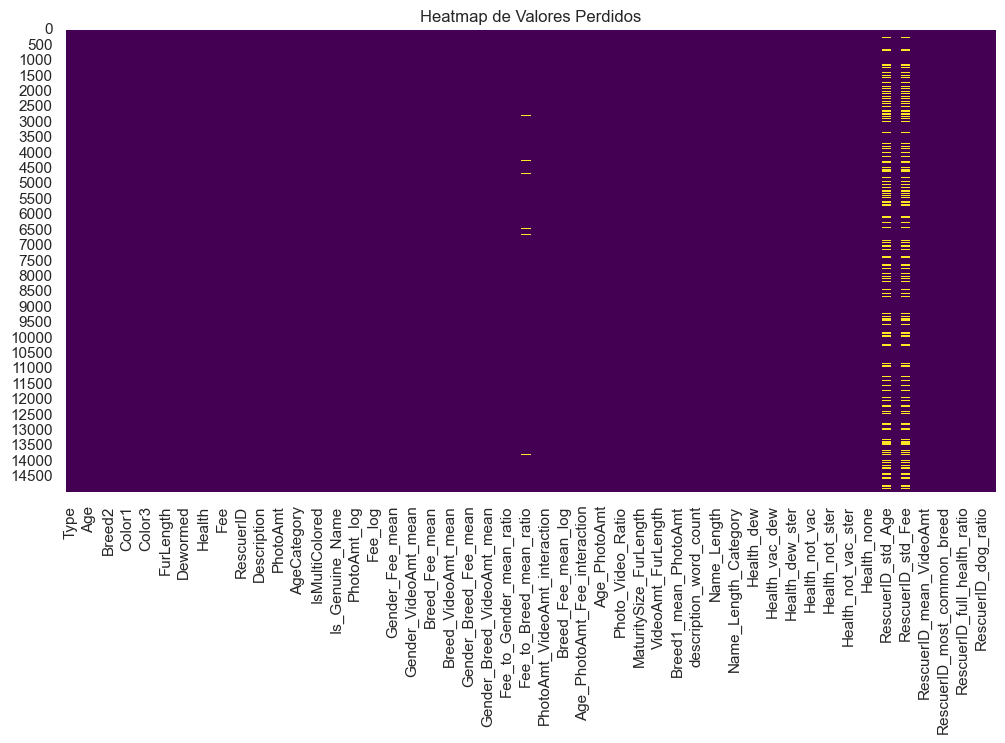

In [8]:
run_eda(dataset, numeric_cols, categorical_cols, "valores perdidos")

### Distribución variables numéricas

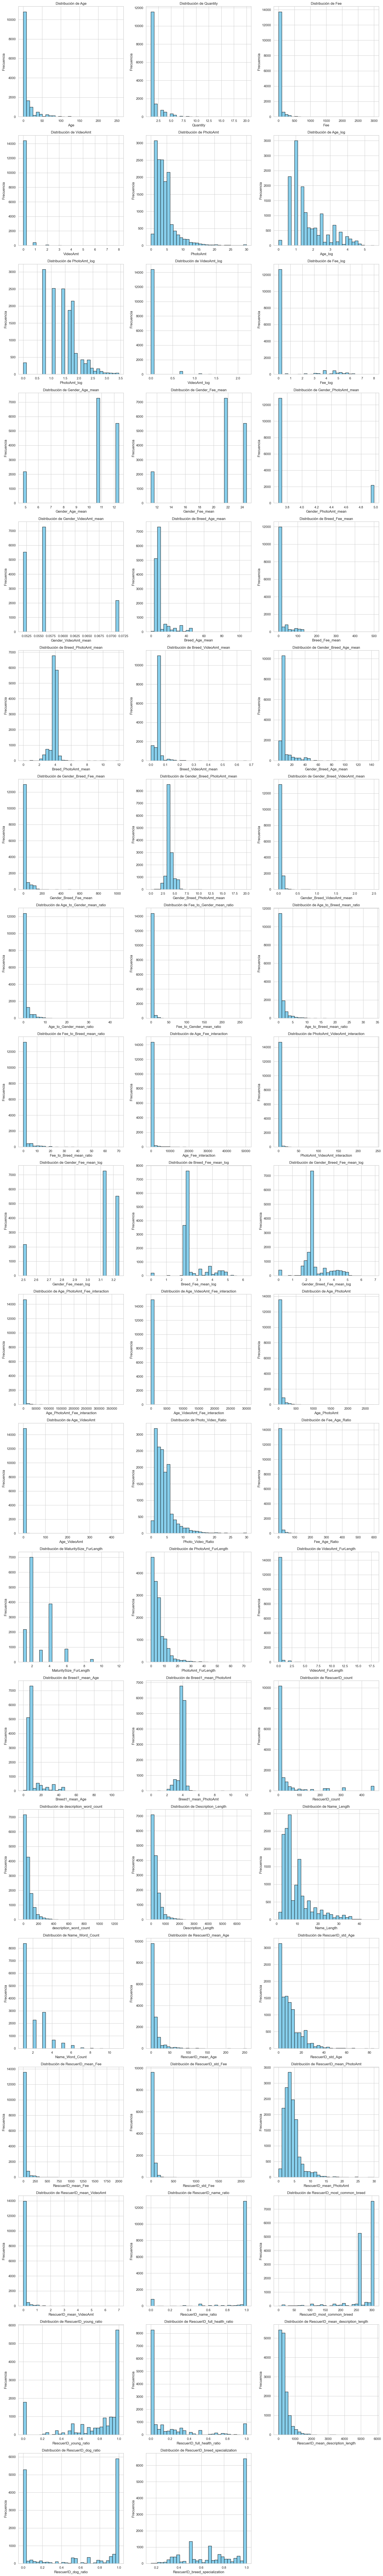

In [9]:
run_eda(dataset, numeric_cols, categorical_cols, "distribucion variables numericas")

### Distribución variables categóricas

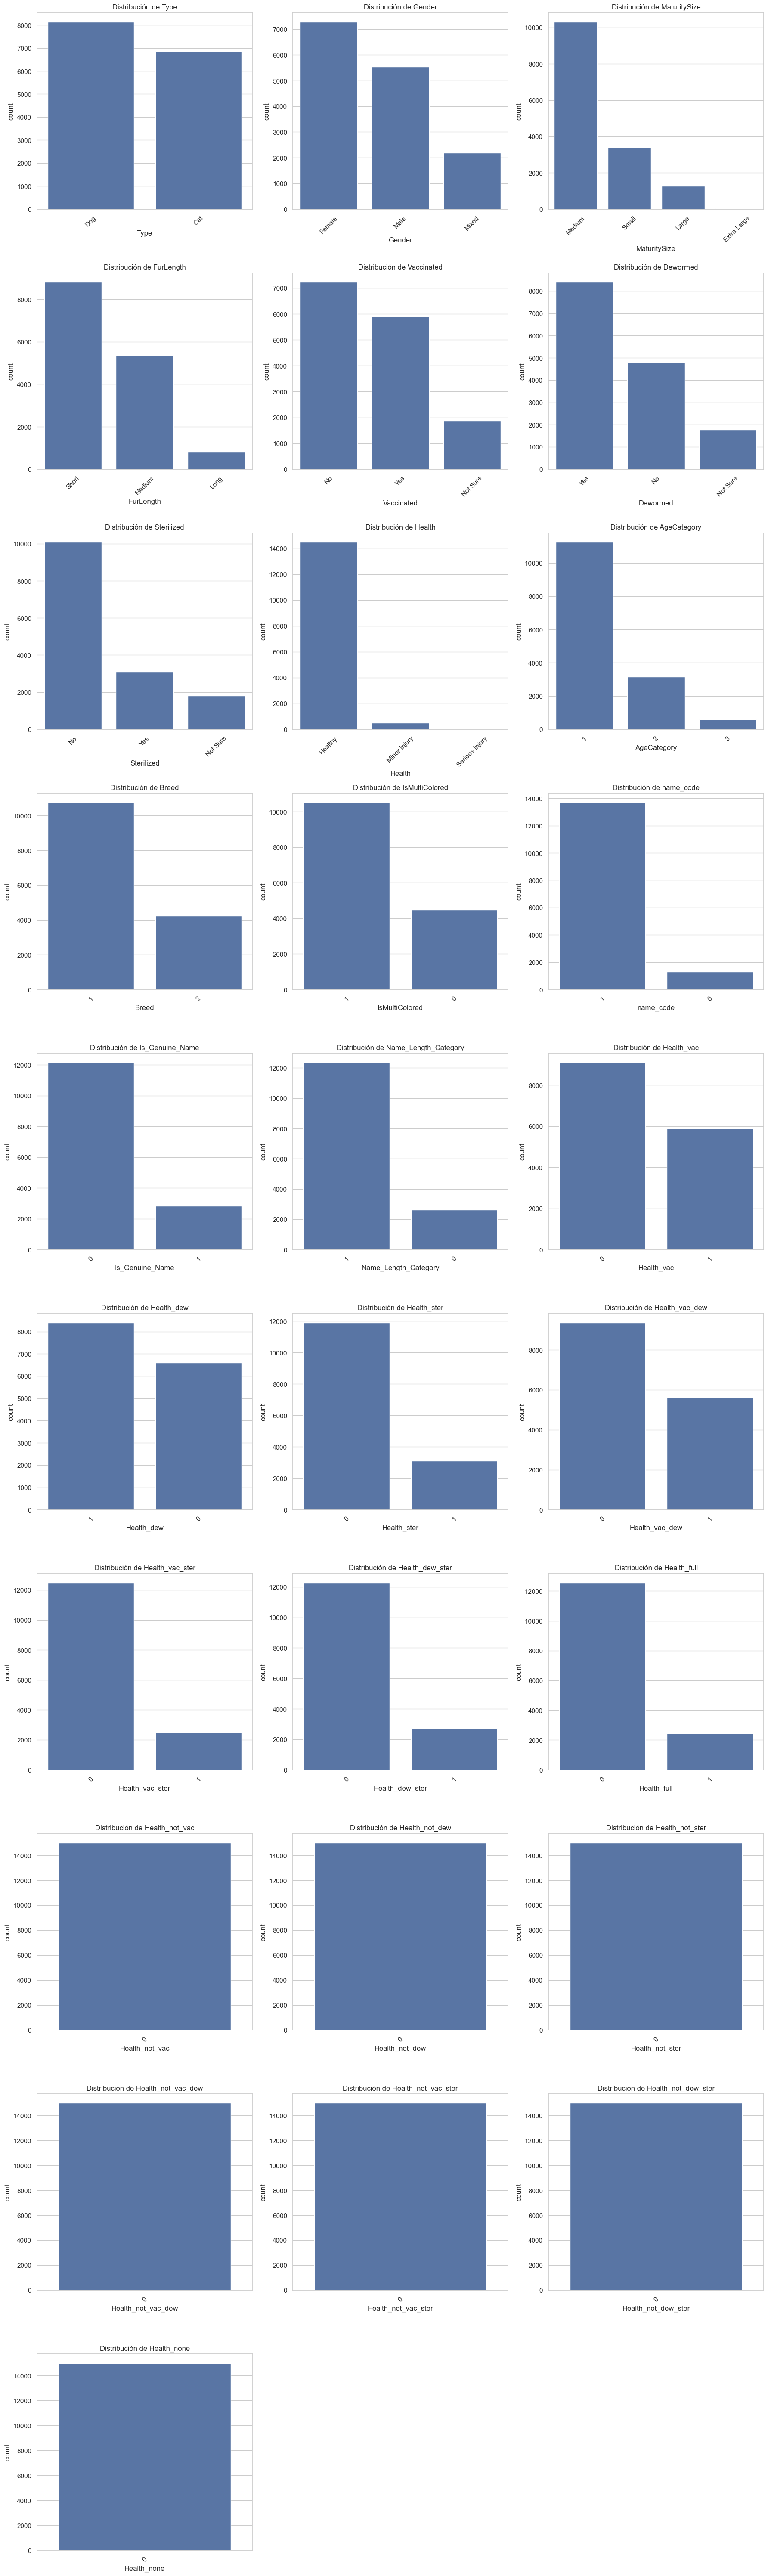

In [10]:
run_eda(dataset, numeric_cols, categorical_cols, "distribucion variables categoricas")

### Distribución variable respuesta "AdoptionSpeed"

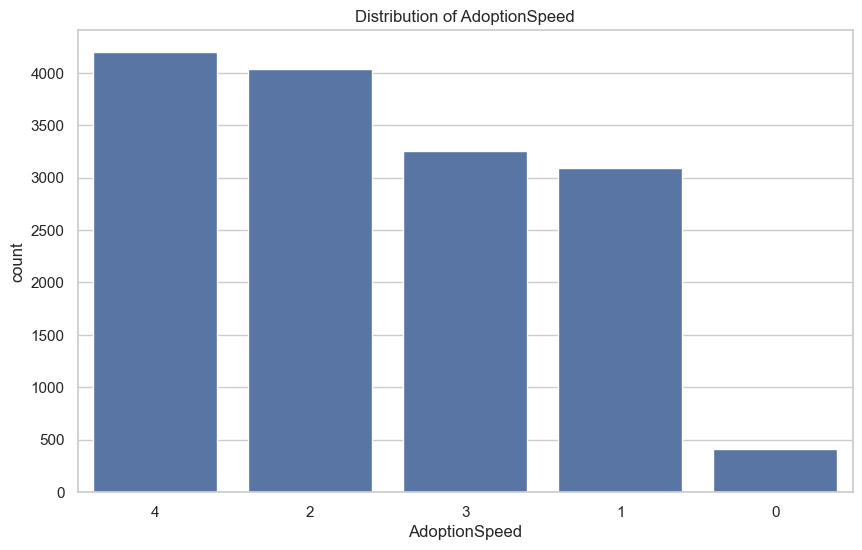

In [11]:
run_eda(dataset, numeric_cols, categorical_cols, "distribucion variable respuesta")

### Relación variables categóricas con "AdoptionSpeed"

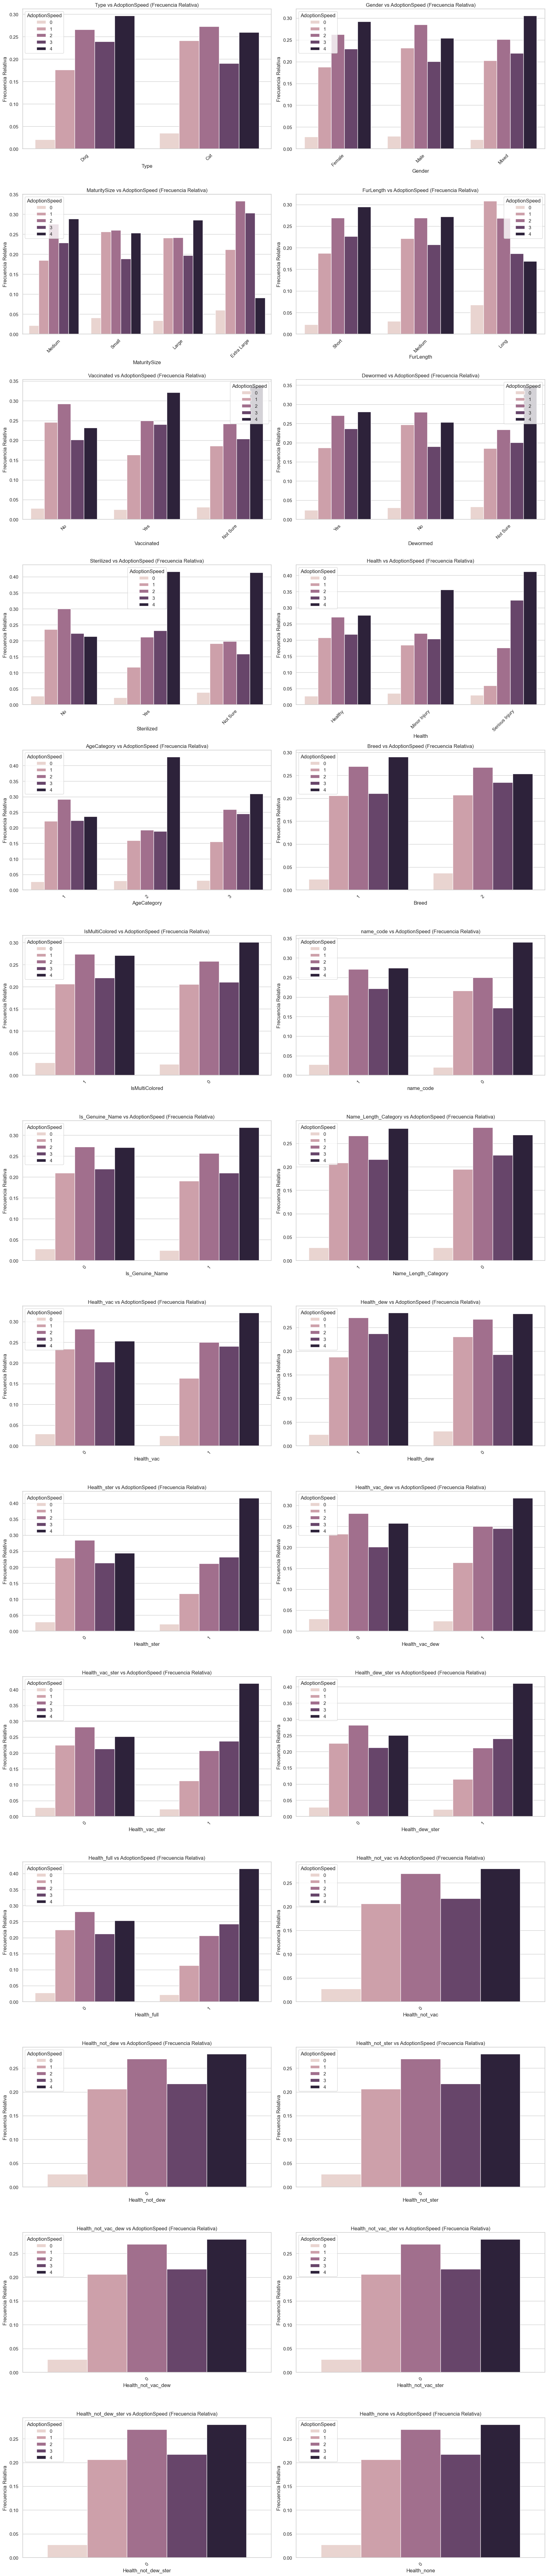

In [12]:
run_eda(dataset, numeric_cols, categorical_cols, "relacion variables categoricas con respuesta")

### Relación variables numéricas con "AdoptionSpeed"

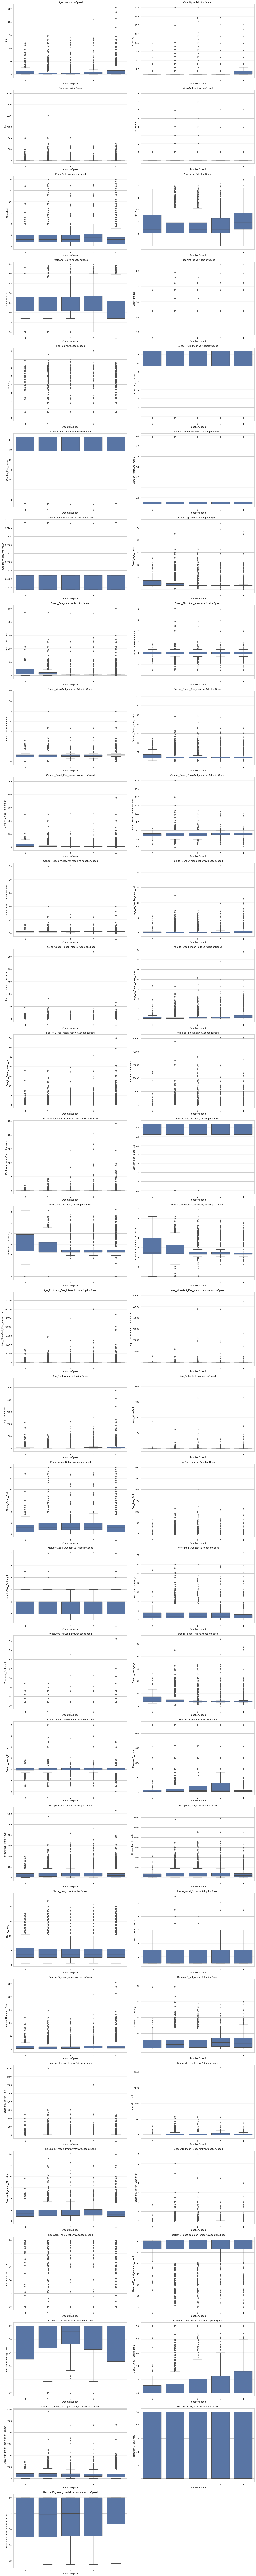

In [13]:
run_eda(dataset, numeric_cols, categorical_cols, "relacion variables numericas con respuesta")

### Matriz Correlación

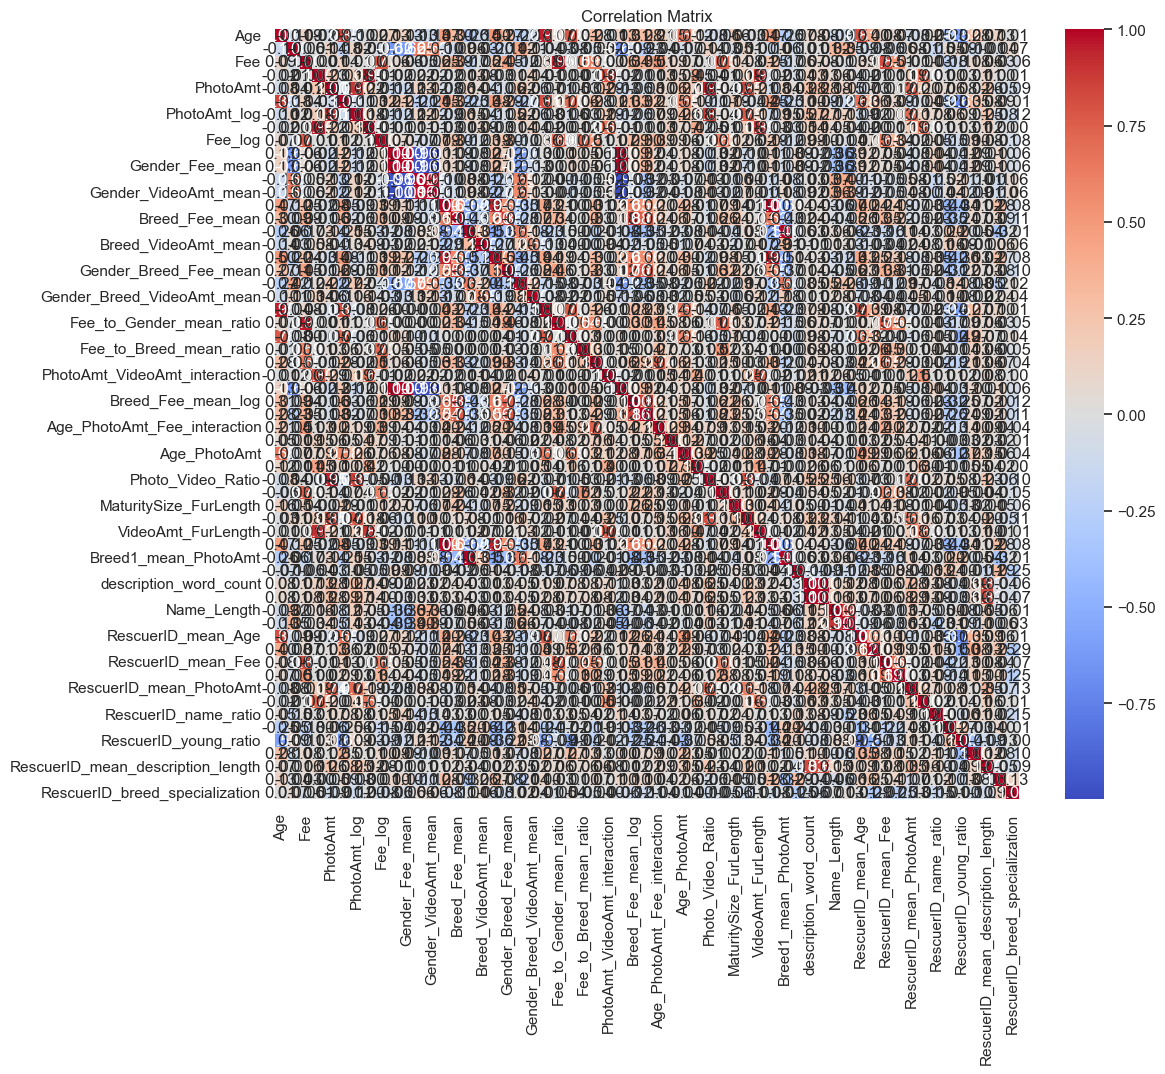

In [14]:
run_eda(dataset, numeric_cols, categorical_cols, "matriz correlacion")

In [15]:
dataset["RescuerID_Word_Count"].value_counts()

KeyError: 'RescuerID_Word_Count'

In [ ]:
dataset["RescuerID_Length"].value_counts()

## BORRAR!

Campos que podríamos agregar:

* Combinaciones de "dewormed" y "sterilized".

* Combinaciones de "vaccinated" y "sterilized".

* Combinaciones de "dewormed" y "vaccinated".

* Combinaciones de "vaccinated", "dewormed" y "sterilized". (FedeR estaba trabajando en el data engineering con esto)

* Edad y "sterilized" (¿edad menor a 7 años y "sterilized"? ¿Cuándo se esterilizan?).

* sin_nombre: (FedeR ya lo hizo).

* Longitud de nombres.

* Rellenar valores nulos en el campo "nombre".

* Si tiene al menos un video.

* Si tiene al menos una foto.

* analisis descripciones (FedeR)

FedeG propone agrupar graficos que muestran lo mismo juntos, ej. las distribuciones de las variables categoricas, numericas...

Ralizar un balanceo de las clases?